In [39]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

In [36]:
import warnings
warnings.filterwarnings("ignore")

## 加载原始数据

In [211]:
import pickle
pkl_file = open('datas/linear_data.pkl', 'rb')
X_train, X_test, y_train, y_test = pickle.load(pkl_file)

In [212]:
X_train.shape

(80, 1)

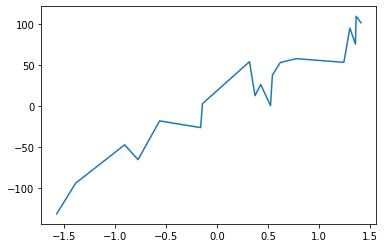

In [213]:
plt.plot(X_test, y_test)

## 基础线性回归

In [214]:
class Regression(object):
    
    """
        基础线性回归模型，使用输入的X和y进行参数回归
        超参：
        n_iterations:int 训练的步数，迭代多少次
        learning_rate:float 学习率
        
        内部函数:
        initialize_weights:初始化参数
        fit:开始训练
        predict:预测
        
        内部的数据:
        n_iterations
        learning_rate
        regularization:正则化参数
        regularization.grad:正则化的梯度函数
    """
    
    def __init__(self, n_iterations, learning_rate):
        self.n_iterations=n_iterations
        self.learning_rate=learning_rate
        self.regularization=lambda x:0
        self.regularization.grad=lambda x:0
    
    def initialize_weights(self, n_features):
        """初始化系数，输入是feature的个数，输出是一个随机初始化好的参数矩阵,[-1/sqrt(N),1/sqrt(N)]"""
        # 实验得出经典算法，随机分布初始化系数
        limit=1/math.sqrt(n_features)
        self.w=np.random.uniform(-limit,limit,(n_features,))
        #Uniform Distribution/Xavier/MSRA/Gaussian 高斯初始化
    
    def fit(self, X, y):
        #插入偏置列1到X中
        X = np.insert(X,0,1,axis=1)#给每一行的第0列增加一个1
        self.training_errors = []#保存每一次步长的训练Loss
        self.initialize_weights(n_features=X.shape[1])#初始化参数w
        
        #进行梯度下降迭代
        for i in range(self.n_iterations):
            y_pred=X.dot(self.w)#进行预测
            #计算Loss
            mse=np.mean(0.5*(y-y_pred)**2+self.regularization(self.w))
            self.training_errors.append(mse)#将Loss加入到training_errors的数组中
            #计算带有正则化项的梯度
            g_w=-(y-y_pred).T.dot(X)/len(X)+self.regularization.grad(self.w)
            #根据梯度下降的算法更新参数
            self.w-=self.learning_rate*g_w
            
    def predict(self,X):
        #通过输入X预测一个样本
        X=np.insert(X,0,1,axis=1)
        pred=X.dot(self.w)
        return pred

In [215]:
def test_and_draw(model):
    y_pred=model.predict(X_test)
    #print(y_pred.shape)
    mse=mean_squared_error(y_test,y_pred)
    print("方差:",mse)
    plt.plot(X_test,y_test,'k.')
    plt.plot(X_test,y_pred,'Y')

In [216]:
class l1_regularization():
    """L1正则化类/函数
    参数:
    
    alpha--L1正则化系数
    """
    def __init__(self, alpha):
        self.alpha=alpha
    def __call__(self,w):
        return self.alpha*np.linalg.norm(w,ord=1)
    def grad(self,w):
        #w>0->w`=1;w<0->w`=0;w==0->w`=0
        return self.alpha*np.sign(w)

In [217]:
class l2_regularization():
    """L2正则化参数
    参数：
    
    alpha 正则化系数
    """
    def __init__(self,alpha):
        self.alpha=alpha
    
    def __call__(self,w):
        return self.alpha*0.5*w.T.dot(w)
    
    def grad(self,w):
        return self.alpha*w

In [218]:
class l1_l2_regularization():
    """使用在ElasticNet中的正则化"""
    
    def __init__(self,alpha,l1_ratio=0.5):
        self.alpha=alpha
        self.l1_ratio=l1_ratio
    
    def __call__(self,w):
        l1_loss=self.l1_ratio*np.linalg.norm(w,ord=1)
        l2_loss=(1-self.l1_ratio)*0.5*w.T.dot(w) #np.linalg.norm(w,ord=2)**2
        return self.alpha*(l1_loss+l2_loss)
    def grad(self,w):
        l1_grad=self.l1_ratio*np.sign(w)
        l2_grad=(1-self.l1_ratio)*w
        return self.alpha*(l1_grad+l2_grad)

<br><br>

## 构造多项式特征
一阶多项式:x,y,z,x2,x3,x4....

二阶多项式:x1^2,x2^2,x3^2,x1x2,x1x3,x2x3

三阶多项式:x1^3,x1x1x2,x1x2x3....


In [219]:
from itertools import combinations_with_replacement

def polynomial_features(X, degree):
    n_samples, n_features=np.shape(X) #行数、列数
    
    #对于每一行的Feature构造排列组合，根据排列组合进行特征的乘积，形成新的X`
    def index_combinations():
        combs=[combinations_with_replacement(range(n_features),i) for i in range(0,degree+1)]
        new_combs=[item for sub in combs for item in sub]
        return new_combs
#     print("Feature 列的排列组合:->", [x for x in index_combinations()])
    
    comb=index_combinations()
    feature_length=len(comb)
    output=np.empty((n_samples, feature_length))
    print(output.shape) 
    for i,index_combs in enumerate(comb):
        output[:,i]=np.prod(X[:, index_combs], axis=1)
    return output 

In [220]:
polynomial_features(np.array([[1,2]]),degree=1)

(1, 3)


array([[1., 1., 2.]])

In [221]:
polynomial_features(np.array([[1,2],[4,5]]),degree=2)

(2, 6)


array([[ 1.,  1.,  2.,  1.,  2.,  4.],
       [ 1.,  4.,  5., 16., 20., 25.]])

In [222]:
polynomial_features(np.array([[1,2],[4,5]]),degree=3)

(2, 10)


array([[  1.,   1.,   2.,   1.,   2.,   4.,   1.,   2.,   4.,   8.],
       [  1.,   4.,   5.,  16.,  20.,  25.,  64.,  80., 100., 125.]])

In [223]:
for x in combinations_with_replacement([0,1],3):print(x)

(0, 0, 0)
(0, 0, 1)
(0, 1, 1)
(1, 1, 1)


## 多项式回归

多个特征的数据不实用

In [224]:
class PolyRegression(Regression):
    """多项式回归就是将原来的feature转化成多阶的新feature，之后进行线性回归:
    
    ------------------------------------------
    degree:最大的阶数
    n_iterations:float
    learning_rate:float
    
    """
    def __init__(self,degree,n_iterations=3000,learning_rate=0.01):
        self.degree=degree
        self.regularization=lambda x:0
        self.regularization.grad=lambda x:0
        super(PolyRegression,self).__init__(n_iterations=n_iterations,learning_rate=learning_rate)
        
    def fit(self,X,y):
        X=polynomial_features(X, degree=self.degree)
        super(PolyRegression,self).fit(X,y)
        
    def predict(self,X):
        X=polynomial_features(X, degree=self.degree)
        return super(PolyRegression,self).predict(X)

In [225]:
model=PolyRegression(degree=3)

In [226]:
model.fit(X_train, y_train)

(80, 4)


(20, 4)
方差: 295.017150962139


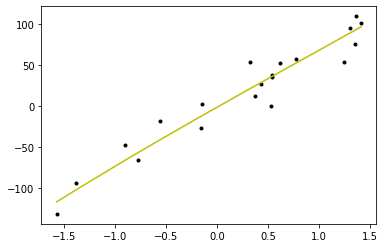

In [227]:
test_and_draw(model)

### 数据的Normalize变换(归一化操作)

行归一化

In [228]:
def normalize(X,axis=-1,order=2):
    "将数据集的每一行进行列的归一化--每一行的向量的L2范数归一"
    L2=np.linalg.norm(X, order, axis)
    L2[L2==0]=1 #为了滤掉为0的L2距离，在归一化的时候会出现除零问题
    return X/np.expand_dims(L2, axis) #每一行除下去

In [229]:
np.linalg.norm([[1, 2],[3, 4]], ord=2, axis=-1)

array([2.23606798, 5.        ])

In [230]:
np.expand_dims([2.23606798, 5], axis=-1) 

array([[2.23606798],
       [5.        ]])

In [231]:
normalize([[1,2],[3,4]],order=2, axis=-1)

array([[0.4472136 , 0.89442719],
       [0.6       , 0.8       ]])

### 带有多项式的Lasso 回归

In [232]:
class LassoRegression(Regression):
    """带有L1范数的Lasso多项式回归
    ---------------------------
    degree:多项式的最高阶
    alpha:L1的系数
    
    n_iteration:float
    learning_rate:int
    normailzed:bool
    """
    
    def __init__(self,degree,alpha,n_iterations=3000,learning_rate=0.01,normalized=True):
        self.degree=degree
        self.regularization=l1_regularization(alpha=alpha)
        self.normalized=normalized
        super(LassoRegression, self).__init__(n_iterations,learning_rate)
        
    def fit(self,X,y):
        X=polynomial_features(X,degree=self.degree)
        if self.normalized:
            X=normalize(X)
        super(LassoRegression, self).fit(X,y)

    def predict(self,X):
        X=polynomial_features(X,degree=self.degree)
        if self.normalized:
            X=normalize(X)
        return super(LassoRegression, self).predict(X)

In [233]:
model=LassoRegression(degree=5, alpha=1000, n_iterations=2000, learning_rate=0.1)

In [234]:
model.fit(X_train, y_train)

(80, 6)


In [235]:
model.w

array([ -30.94113584,   22.95244389,   96.53289275,   47.37363858,
       -104.96433332,   24.41214081,  186.90986761])

(20, 6)
方差: 383.75734262403637


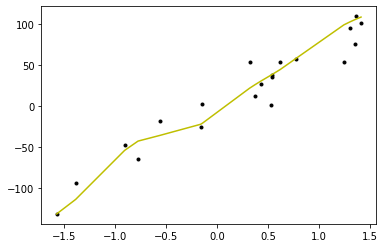

In [236]:
test_and_draw(model)

### 带有多项式的Ridge 回归

In [237]:
class RidgeRegression(Regression):
    """带有多项式和归一化的Ridge回归
    -----------------------------
    degree:最大阶数
    alpha:正则化系数
    n_iterations:步数
    learning_rate:步长
    normalized
    """
    def __init__(self,degree,alpha,n_iterations=3000,learning_rate=0.01,normailzed=True):
        self.degree=degree
        self.regularization=l2_regularization(alpha=alpha)
        self.normalized=normailzed
        super(RidgeRegression,self).__init__(n_iterations,learning_rate)
        
    def fit(self,X,y):
        X=polynomial_features(X,degree=self.degree)
        if self.normalized:
            X=normalize(X)
        super(RidgeRegression, self).fit(X,y)
    
    def predict(self,X):
        X=polynomial_features(X,degree=self.degree)
        if self.normalized:
            X=normalize(X)
        return super(RidgeRegression,self).predict(X)
    

In [238]:
model=RidgeRegression(degree=5,alpha=100,n_iterations=1000,learning_rate=1)

In [239]:
model.fit(X_train,y_train)

(80, 6)


(20, 6)
方差: 350.5175685249791


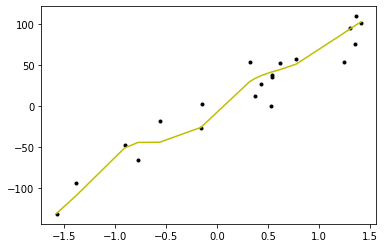

In [240]:
test_and_draw(model)

### 带有多项式的ElasticNet 回归

In [241]:
class ElasticNetRegression(Regression):
    """
    带有L1L2调和的线性回归
    
    -----------------
    degree
    alpha
    l1_ratio
    n_iterations
    learning_rate
    normalized
    """
    def __init__(self,degree,alpha=0.5,l1_ratio=0.5,n_iterations=3000,learning_rate=0.01,normalized=True):
        self.degree=degree
        self.regularization=l1_l2_regularization(alpha=alpha,l1_ratio=l1_ratio)
        self.normalized=normalized
        super(ElasticNetRegression,self).__init__(n_iterations,learning_rate)
        
    def fit(self,X,y):
        X=polynomial_features(X,degree=self.degree)
        if self.normalized:
            X=normalize(X)
        super(ElasticNetRegression,self).fit(X,y)
    
    def predict(self,X):
        X=polynomial_features(X,degree=self.degree)
        if self.normalized:
            X=normalize(X)
        return super(ElasticNetRegression,self).predict(X)
    

In [242]:
model=ElasticNetRegression(degree=3,alpha=2000,l1_ratio=0.8,n_iterations=1000,learning_rate=0.01)

In [243]:
model.fit(X_train,y_train)

(80, 4)


(20, 4)
方差: 405.6138475958538


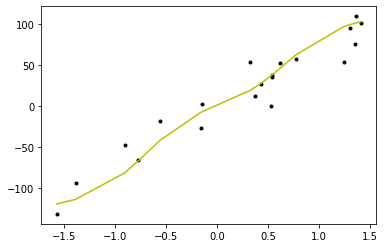

In [244]:
test_and_draw(model)

<br><br>

## 读入真实的数据

In [254]:
from sklearn.model_selection import train_test_split
train=pd.read_csv('datas/house_data.csv')
y=np.asarray(train['SalePrice'])
train1=train.drop(['Id','SalePrice'],axis=1)
X=np.asarray(pd.get_dummies(train1).reset_index(drop=True))
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=123)

In [255]:
model=ElasticNetRegression(degree=1,alpha=1000, l1_ratio=0.5, n_iterations=80000,learning_rate=0.001)

In [257]:
model.fit(X_train, y_train)

(1168, 304)


In [258]:
pred=model.predict(X_test)

(292, 304)


In [259]:
# 预测立群点，失败的数据
logrmse=np.sqrt(mean_squared_error(np.log(abs(y_test)),np.log(abs(pred))))

In [260]:
logrmse

0.3455434843861849

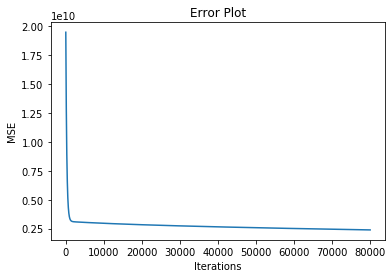

In [261]:
n=len(model.training_errors)
training=plt.plot(range(n), model.training_errors, label="Training Error")
#plt.legend(handles=[training])
plt.title("Error Plot")
plt.ylabel('MSE')
plt.xlabel('Iterations')
plt.show()

### 数据RobustScaler归一化

In [262]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler

In [266]:
def benchmark(model,testset, label):
    pred=model.predict(testset)
    #print(pred)
    if pred[pred<0].shape[0]>0:
        print("Neg Value")
        return -1
    rmse=np.sqrt(mean_squared_error(label,pred))
    lrmse=np.sqrt(mean_squared_error(np.log(label),np.log(abs(pred))))
    print("RMSE:",rmse)
    print("LRMSE:",lrmse)
    return lrmse

In [267]:
def train_test():
    model=make_pipeline(RobustScaler(), ElasticNetRegression(degree=1,alpha=1000,l1_ratio=0.5,n_iterations=80000,learning_rate=0.001))
    model.fit(X_train,y_train)
    lrmse=benchmark(model, X_test, y_test)
    

In [268]:
train_test()

(1168, 304)
(292, 304)
RMSE: 51120.0079643827
LRMSE: 0.2421903404751488


<br><br><br>
## 普通多项式回归

In [269]:
import pandas as pd
import numpy as np
from random import choice  
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

In [289]:
def create_points():
    n=5
    x = np.linspace(0,9, n)
    y2 = x*x - 10*x+2 + np.random.randn(n) #构造数据
    return x,y2

In [290]:
def create_test():
    n=150
    xtest = np.linspace(0,9,n)
    ytest = xtest*xtest - 10*xtest + 2 + np.random.randn(n)# x^2 + x +2 
    return xtest,ytest

In [291]:
def ploy_info():
    poly1 = PolynomialFeatures(1)
    poly2 = PolynomialFeatures(2)
    polym = PolynomialFeatures(7)
    return poly1,poly2,polym

In [292]:
# [x1,x2] -> [1,x1,x2,x1^2,x1*x2,x2^2]

In [293]:
xtrain,ytrain=create_points()
xtest,ytest = create_test()

In [294]:
poly1,poly2,polym = ploy_info()

In [295]:
## 一阶
xtrain_ploy1 = poly1.fit_transform(xtrain.reshape(-1,1))

linemodel_ploy1 = LinearRegression()

linemodel_ploy1.fit(xtrain_ploy1,ytrain) # train

ploy1_pred = linemodel_ploy1.predict(poly1.transform(xtest.reshape(-1,1)))

In [279]:
# 二阶
xtrain_ploy2 = poly2.fit_transform(xtrain.reshape(-1,1))

linemodel_ploy2 = LinearRegression()

linemodel_ploy2.fit(xtrain_ploy2,ytrain)

ploy2_pred = linemodel_ploy2.predict(poly2.transform(xtest.reshape(-1,1)))

In [280]:
# 多阶
xtrain_polym = polym.fit_transform(xtrain.reshape(-1,1))

linemodel_polym = LinearRegression()

linemodel_polym.fit(xtrain_polym,ytrain)

polym_pred = linemodel_polym.predict(polym.transform(xtest.reshape(-1,1)))

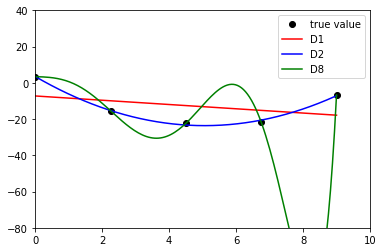

In [281]:
plt0,  = plt.plot(xtrain,ytrain,'ko',label="true value")
plt1,  = plt.plot(xtest,ploy1_pred,'r',label="D1")
plt2,  = plt.plot(xtest,ploy2_pred,'b',label="D2")
plt3,  = plt.plot(xtest,polym_pred,'g',label="D8")


plt.legend(handles=[plt0, plt1, plt2, plt3])
plt.axis([0, 10, -80, 40])
plt.show()

## 正则化效果

In [282]:
alpha=500
max_iter=40000

In [283]:
# Ridge
xtrain_polym = polym.fit_transform(xtrain.reshape(-1,1))

Ridge_polym = Ridge(alpha=alpha,max_iter=max_iter)

Ridge_polym.fit(xtrain_polym,ytrain)

Ridge_pred = Ridge_polym.predict(polym.transform(xtest.reshape(-1,1)))

In [284]:
# LASSO
xtrain_polym = polym.fit_transform(xtrain.reshape(-1,1))

Lasso_polym = Lasso(alpha=alpha,max_iter=max_iter)

Lasso_polym.fit(xtrain_polym,ytrain)

Lasso_pred = Lasso_polym.predict(polym.transform(xtest.reshape(-1,1)))

In [285]:
# ElasticNet
xtrain_polym = polym.fit_transform(xtrain.reshape(-1,1))

ElasticNet_polym = ElasticNet(alpha=alpha,max_iter=max_iter,l1_ratio=0.2)

ElasticNet_polym.fit(xtrain_polym,ytrain)

ElasticNet_pred = ElasticNet_polym.predict(polym.transform(xtest.reshape(-1,1)))

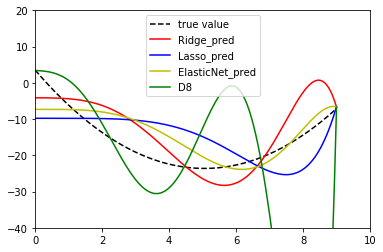

In [286]:
plt0,  = plt.plot(xtest,ploy2_pred,'k--',label="true value")
plt1,  = plt.plot(xtest,Ridge_pred,'r',label="Ridge_pred")
plt2,  = plt.plot(xtest,Lasso_pred,'b',label="Lasso_pred")
plt3,  = plt.plot(xtest,ElasticNet_pred,'y',label="ElasticNet_pred")
plt4,  = plt.plot(xtest,polym_pred,'g',label="D8")

plt.legend(handles=[plt0, plt1, plt2, plt3, plt4])
plt.axis([0, 10, -40, 20])
plt.show()

In [288]:
LinearRegression?

Init signature: LinearRegression(fit_intercept=True, normalize=False, copy_X=True, n_jobs=None)
Docstring:     
Ordinary least squares Linear Regression.

Parameters
----------
fit_intercept : boolean, optional, default True
    whether to calculate the intercept for this model. If set
    to False, no intercept will be used in calculations
    (e.g. data is expected to be already centered).

normalize : boolean, optional, default False
    This parameter is ignored when ``fit_intercept`` is set to False.
    If True, the regressors X will be normalized before regression by
    subtracting the mean and dividing by the l2-norm.
    If you wish to standardize, please use
    :class:`sklearn.preprocessing.StandardScaler` before calling ``fit`` on
    an estimator with ``normalize=False``.

copy_X : boolean, optional, default True
    If True, X will be copied; else, it may be overwritten.

n_jobs : int or None, optional (default=None)
    The number of jobs to use for the computation. Thi